In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy.signal import butter,filtfilt
import cv2

In [ ]:
!wget -q --show-progress --no-check-certificate 'https://docs.google.com/uc?export=download&id=198jqSAnnh34gG1eEqEk3lrwczvqtTNWa' -O lena_256.png

lena_256.png        100%[===================>]  46.95K  --.-KB/s    in 0s      


## Foveation Filtering

In [ ]:
D = 30
G = 18
E = 0.2
T = 0
Id = 9
Fmin = 0.07
alpha = 0.54

In [ ]:
def eccentricity(id,ip,vd,dx):
  x = (id*dx)/(ip*vd)
  return np.arctan(x)

In [ ]:
def fdx(gamma,eccen,eeta,tow):
  return gamma/(eccen + eeta)-tow

In [ ]:
def bx(e,vd,dx):
  part1 = e/(2*vd) + dx/vd
  part2 = -e/(2*vd) + dx/vd

  return np.arctan(part1) - np.arctan(part2)

In [ ]:
def fpn(beta,mdf,fmin):
  return max(fmin,min(beta*mdf,0.5))

In [ ]:
def get_cutoff_frequencies(I,x_fp,y_fp,dist_viewer,img_size,gamma,eeta,tow,f_min):
  m,n = I.shape
  img_pixels = m

  c_freq = np.zeros((m,n),dtype=float)
  for i in range(m):
    for j in range(n):

      dist_foveation_point = math.sqrt(((i-x_fp)**2)+((j-y_fp)**2))             # distance of point from foveation point
      e = eccentricity(img_size,img_pixels,dist_viewer,dist_foveation_point)    # eccentricity value which is basically angle subtended at viewer

      mdf = fdx(gamma,e,eeta,tow)                                         # maximum detectable frequency
      beta = bx(img_size/img_pixels,dist_viewer,dist_foveation_point)     # beta value as per paper
      
      cut_freq = fpn(beta,mdf,f_min)
      c_freq[i][j] = 2*np.pi*cut_freq           # wc for each pixel

  return c_freq

In [ ]:
print(np.sinc(3))
np.sinc(-3)

3.8981718325193755e-17


3.8981718325193755e-17

In [ ]:
def h(wc,i,n):
  
  if abs(i) <= n/2:
    return (wc*np.sinc(wc*i))/np.pi
  else:
    return 0

In [ ]:
def w(i,n):
  return alpha + (1-alpha)*np.cos(2*np.pi*i/n)

In [ ]:
def l(wc,i,n):
  return h(wc,i,n)*w(i,n)

In [ ]:
n = 5
np.arange(n)-n//2

array([-2, -1,  0,  1,  2])

In [ ]:
# Implementation of foveation filtering.
def fov_filt(I):

  m,n = I.shape
  cut_freq = get_cutoff_frequencies(I,m/2,n/2,D,Id,G,E,T,Fmin)

  Icap = np.zeros((m,n),dtype=float)
  for n1 in range(-m//2,m//2):
    for n2 in range(-n//2,n//2):
      
      wc = cut_freq[n1+m//2][n2+n//2]
      val = 0
      for i1 in range(-m//2,m//2):
        inner = 0
        for i2 in range(-n//2,n//2):
          
          x = n1-i1+m//2
          y = n2-i2+n//2

          if x>=0 and x<m and y>=0 and y<n:
            inner = inner + I[x][y]*l(wc,i2,n) 
        
        val = val + inner*l(wc,i1,m)
      
      Icap[n1+m//2][n2+n//2] = val
  
  return Icap

In [ ]:
# Efficient implementation of the above filtering technique
def fov_filt_mat(I):

  m,n = I.shape
  cut_freq = get_cutoff_frequencies(I,m/2,n/2,D,Id,G,E,T,Fmin)
  I_padded = np.pad(I,((m//2,m//2),(n//2,n//2)), 'constant', constant_values=(0,0))

  Icap = np.zeros((m,n),dtype=float)
  for n1 in range(m):
    for n2 in range(n):

      wc = cut_freq[n1][n2]

      Lx = []
      for i1 in range(-m//2,m//2):
        Lx.append(l(wc,i1,m))
      Lx = np.array(Lx).reshape(-1,1)

      Ly = []
      for i1 in range(-n//2,n//2):
        Ly.append(l(wc,i1,n))
      Ly = np.array(Ly).reshape(-1,1)

      L = np.dot(Lx,Ly.T)
      A = I_padded[n1:n1+m,n2:n2+n]
      val = np.sum(L*A)
      
      Icap[n1][n2] = val
  
  return Icap






### Implementing the above foveation technique on image size of 128x128

(256, 256)


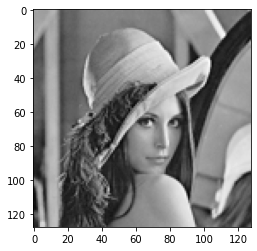

In [ ]:
from PIL import Image as im
from PIL import ImageOps as imo

lenna = im.open('/content/lena_256.png')

lenna_gray = np.array(imo.grayscale(lenna))
print(lenna_gray.shape)



from PIL import Image

lenna_gray = np.array(im.fromarray(lenna_gray).resize((128,128)))
plt.imshow(lenna_gray, cmap = 'gray')

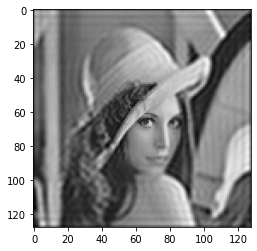

In [ ]:
trans_img = fov_filt_mat(lenna_gray)
plt.imshow(trans_img, cmap = 'gray')